---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia de Computação e Automação

ELE0606 - Tópicos especiais em inteligência artificial

Student: Levy Gabriel da Silva Galvão

Título: Comparison between brute force and Sklearn Gaussian Naive Bayes implementation

---

# Libraries import

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time

# Scipy
import scipy.stats as stats

# Model persistence
from joblib import dump, load

# Machine Learning
from sklearn.utils import shuffle   
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, \
                                    RandomizedSearchCV, \
                                    train_test_split 
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import StandardScaler, \
                                  MinMaxScaler
from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            plot_confusion_matrix

# Brute force utils
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Dataset

The objective of this analysis is to compare a brute force implementation of a Gaussian Naive Bayes classifier against the Skelearn implementation. Furthermore comparing the results with the KNN implementation obtained in previous works (https://github.com/Lwao/awesome-ai/blob/main/ufrn-ai/scikit-example-kit/knn_wine.ipynb).

Two datasets will be used, one with binary classification and other with multiclass classification. 

The first one for binary classification (https://github.com/dhirajk100/Naive-Bayes/blob/master/Naive-Bayes-Classification-Data.csv) is a dataset to identify if a individual has diabetes based in the feature columns of **glucose** level and **blood pressure**.

The second one is the wine dataset (https://archive.ics.uci.edu/ml/datasets/wine) that contains the information about 13 feature attributes that links to three different classes of wine.

Right below both datasets are loaded into different variables to start the analysis. It is important to see that when using the pandas method `info()` some features about the quality of the dataset are shown. Based on this information, there is no need in cleaning the dataset, once it is already fit for training.

For the diabetes dataset:

In [2]:
url = 'https://raw.githubusercontent.com/dhirajk100/Naive-Bayes/master/Naive-Bayes-Classification-Data.csv'
df_diabetes = pd.read_csv(url)
df_diabetes = df_diabetes.rename(columns={'diabetes': 'target'})
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   glucose        995 non-null    int64
 1   bloodpressure  995 non-null    int64
 2   target         995 non-null    int64
dtypes: int64(3)
memory usage: 23.4 KB


For the wine dataset:

In [3]:
filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df_wine = pd.read_csv(filename, header=None)
df_wine.columns = ['target', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
              'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines', 'proline']
features = np.array(df_wine.drop(columns=['target']))
targets = np.array(df_wine['target'])

df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  OD280/OD315_of_diluted_wines  178 non-null    float64
 13  proli

The function below helps to split the features map from the targets:

In [4]:
def split_features_n_targets(dataset, target_label='target'): 
  features = np.array(dataset.drop(columns=[target_label]))
  targets = np.array(dataset.filter([target_label]))
  return features, targets

# Normalization

The scaler used in all simulations is the min-max scaler. To help find the parameters for the scaler, the function `fit_minmax` is implemented.

In [5]:
def fit_minmax(features):
  max_ = features.max(axis=0)
  min_ = features.min(axis=0)
  return (features-min_)/(max_-min_)

Bellow the Sklearn class `MinMaxScaler()` is fitted for both datasets.

In [6]:
scaler_diabetes = MinMaxScaler()
scaler_wine = MinMaxScaler()

feat_diabetes, targ_diabetes = split_features_n_targets(df_diabetes)
feat_wine, targ_wine = split_features_n_targets(df_wine)

scaler_diabetes.fit(feat_diabetes)
scaler_wine.fit(feat_wine)

MinMaxScaler()

# Sampling

The test are made varying the percentage of the dataset used so the model generalization can be evaluated. Therefore right below a sampling function is defined so the user can set the percentage used for the training set.

In [7]:
def sample_class(data, per=0.1):
  size = len(data.index)
  per_size = int(per*size)
  return data.sample(n=per_size, replace=True)

The Sklearn library also offers a function capacble of doing this sort of sampling, thus called `sklearn.model_selection.train_test_split` that will be used in the Sklearn implementation.

Also an accuracy table will be used to gather all sampling cases and iterations of the algorithm. Below is the implementation and a visual example with random data

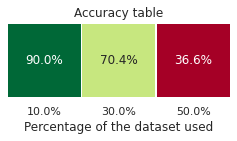

In [8]:
def plot_accuracy_table(table, xticks, title='Accuracy table'):
  sns.set(font_scale=1)
  f, heatmap = plt.subplots(figsize=(4, 3))
  heatmap = sns.heatmap(table, annot=True, fmt=".1%", linewidths=.5, cmap="RdYlGn", cbar=False, square=True)
  new_ticks = [str(x*100)+'%' for x in xticks]
  heatmap.set_xticklabels(new_ticks)
  heatmap.set_yticklabels('')
  plt.xlabel("Percentage of the dataset used") 
  plt.title(title);

test_table = np.random.rand(1, 3)
per_cases = [0.1, 0.3, 0.5]
plot_accuracy_table(test_table, per_cases)

# Simulation

Both datasets will be analyzed in the single loop. The test consists in doing 10 iterations over the same model to acquire the mean accuracy for all iterations. For each iteration the model must be trained with a varying percetange of data for the train set, varying as `per = [10%, 25%, 50%]` of the dataset.

## Brute force algorithm

Below is implemented each step in the Gaussian Naive Bayes algorithm preparing grounds for the simulation.

In [9]:
class GNB_Classifier: # https://github.com/bamtak/machine-learning-implemetation-python/blob/master/Gaussian%20Naive%20Bayes.ipynb
  def fit(self, X, y, epsilon = 1e-10):
    y = y.reshape(-1)
    self.y_classes, y_counts = np.unique(y, return_counts=True)
    self.x_classes = np.array([np.unique(x) for x in X.T], dtype=object)
    self.phi_y = 1.0 * y_counts/y_counts.sum()
    self.u = np.array([X[y==k].mean(axis=0) for k in self.y_classes])
    self.var_x = np.array([X[y==k].var(axis=0)  + epsilon for k in self.y_classes])
    return self

  def predict(self, X):
      return np.apply_along_axis(lambda x: self.compute_probs(x), 1, X)

  def compute_probs(self, x):
      probs = np.array([self.compute_prob(x, y) for y in range(len(self.y_classes))])
      return self.y_classes[np.argmax(probs)]

  def compute_prob(self, x, y):
      c = 1.0 /np.sqrt(2.0 * np.pi * (self.var_x[y]))
      return np.prod(c * np.exp(-1.0 * np.square(x - self.u[y]) / (2.0 * self.var_x[y])))

  def score(self, X, y):
      return (self.predict(X) == y.reshape(-1)).mean()

Below the whole simulation takes place, containg all 10 iterations.

Duration: 3.040571062 seconds


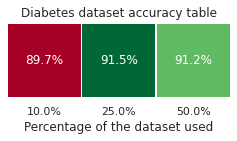

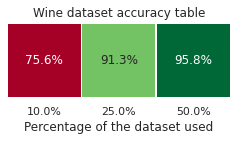

In [10]:
start = time.process_time()

iterations = 10
per = [0.1, 0.25, 0.5]
diabetes_table = np.zeros(len(per))
wine_table = np.zeros(len(per))

for ii in range(iterations): # 10 iterations
  for jj in range(len(per)): # percentage of the dataset for the train set
    #### diabetes dataset
    train = sample_class(df_diabetes, per=per[jj]) # sample data
    X, y = split_features_n_targets(train) # split features and targets
    X = fit_minmax(X) # fit data in [0,1] range
    clf = GNB_Classifier() # brute force classifier
    clf.fit(X, y) # fit data to model
    feat, targ = split_features_n_targets(df_diabetes) # split features and targets for entire dataset
    feat = fit_minmax(feat) # fit data in [0,1] range
    diabetes_table[jj] += clf.score(feat, targ)/iterations # get model score

    #### wine dataset
    train = sample_class(df_wine, per=per[jj]) # sample data
    X, y = split_features_n_targets(train) # split features and targets
    X = fit_minmax(X) # fit data in [0,1] range
    clf = GNB_Classifier() # brute force classifier
    clf.fit(X, y) # fit data to model
    feat, targ = split_features_n_targets(df_wine) # split features and targets for entire dataset
    feat = fit_minmax(feat) # fit data in [0,1] range
    wine_table[jj] += clf.score(feat, targ)/iterations # get model score

plot_accuracy_table(diabetes_table.reshape(1,-1), per, 'Diabetes dataset accuracy table')
plot_accuracy_table(wine_table.reshape(1,-1), per, 'Wine dataset accuracy table')

print('Duration: ' + str(time.process_time()-start) + ' seconds')

## Sklearn implementation

Below the whole simulation takes place, containg all 10 iterations.

Duration: 0.511843947 seconds


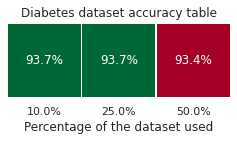

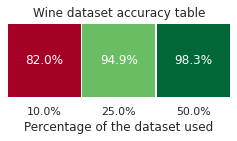

In [11]:
start = time.process_time()

iterations = 10
per = [0.1, 0.25, 0.5]
diabetes_table = np.zeros(len(per))
wine_table = np.zeros(len(per))

for ii in range(iterations): # 10 iterations
  for jj in range(len(per)): # percentage of the dataset for the train set
      # Guassian Naive Bayes model instantiation
      clf = GaussianNB()
    
      #### diabetes dataset
      diabetes_steps = [('scaler', scaler_diabetes), ('clf', clf)] # pipeline steps
      diabetes_pipeline = Pipeline(diabetes_steps) # model pipeline
      train, _ = train_test_split(df_diabetes, train_size=per[jj], random_state=42, shuffle=True) # sample data
      X, y = split_features_n_targets(train) # split features and targets
      diabetes_pipeline.fit(X, y.ravel()) # fit data to model pipeline
      feat, targ = split_features_n_targets(df_diabetes) # split features and targets for entire dataset
      diabetes_table[jj] += diabetes_pipeline.score(feat, targ)/iterations # get model score

      #### wine dataset
      wine_steps = [('scaler', scaler_wine), ('clf', clf)] # pipeline steps
      wine_pipeline = Pipeline(wine_steps) # model pipeline
      train, _ = train_test_split(df_wine, train_size=per[jj], random_state=42, shuffle=True) # sample data
      X, y = split_features_n_targets(train) # split features and targets
      wine_pipeline.fit(X, y.ravel()) # fit data to model pipeline
      feat, targ = split_features_n_targets(df_wine) # split features and targets for entire dataset
      wine_table[jj] += wine_pipeline.score(feat, targ)/iterations # get model score

plot_accuracy_table(diabetes_table.reshape(1,-1), per, 'Diabetes dataset accuracy table')
plot_accuracy_table(wine_table.reshape(1,-1), per, 'Wine dataset accuracy table')

print('Duration: ' + str(time.process_time()-start) + ' seconds')

## Results

Looking towards the accuracy tables for the brute force implementation it is easy to see that the Sklearn implementation shows better capability of generalization, since in most of the cases it shown a better accuracy, losing only when considering the Wine dataset with 10% of the dataset used for training.

Other characteristic that implies that Sklearn is a better approach is the runtime. For all simulations the brute force algothm took more than 2.5 seconds, while de Sklearn approach took less than 0.5 seconds. 

Now considering the Wine dataset, regarding the better accuracy obtained by a KNN model in previous analysis was 98%, losing by a close margin to the 98.3% of the Gaussian Naive  Bayes model. This difference depends on multiples factors, since both models are completly different, once the KNN fetch for nearly neighbors to attribute a class prediction, the Naive Bayes algorithm relies on a likelihood of probabilities for a sample to belong to a given class.
